# Packages

In [59]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# Importation

In [60]:
project_root = Path.cwd().parent
project_root

data_path = (
    project_root
    / "1_data"
    / "processed"
    / "features"
    / "unemployment_features_stationary.csv"
)

data_path

WindowsPath('d:/Portofolio Data science/Time Series/Explainable_AI_Forecast_and_explain_the_Unemployment_of_USA/1_data/processed/features/unemployment_features_stationary.csv')

In [69]:
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
df.head()

,BUSLOANS,CPIAUCSL,DPCERA3M086SBEA,INDPRO,M2SL,OILPRICEX,RPI,SP500,TB3MS,UNRATE,USREC
date,,,,,,,,,,,
1960-01-01,0.011578,-0.006156,0.001204,0.091976,0.001323,0.0,0.020977,0.017909,0.30,-0.8,0.0
1960-02-01,0.011905,-0.003767,0.006009,0.076960,0.002007,0.0,0.014565,-0.025663,-0.19,-1.1,0.0
1960-03-01,-0.008356,-0.005455,0.021240,0.007959,0.001324,0.0,0.006250,-0.070857,-1.18,-0.2,0.0
1960-04-01,-0.009098,0.005090,0.033752,-0.025916,0.000634,0.0,0.006489,-0.040442,-1.12,0.0,0.0
1960-05-01,-0.000359,0.003383,0.009040,-0.018119,0.003977,0.0,0.007747,-0.010090,-0.67,0.0,1.0


# Split

In [70]:
end_time_train = "1989-12" # 

df_train = df[df.index <= end_time_train]
df_test = df[df.index > end_time_train]

In [72]:
print(df_train.index[-1])
print(df_test.index[0])

1989-12-01 00:00:00
1990-01-01 00:00:00


# Analyse bivariée

C:\Users\Mita\AppData\Local\Temp\ipykernel_6088\1160232640.py:32: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


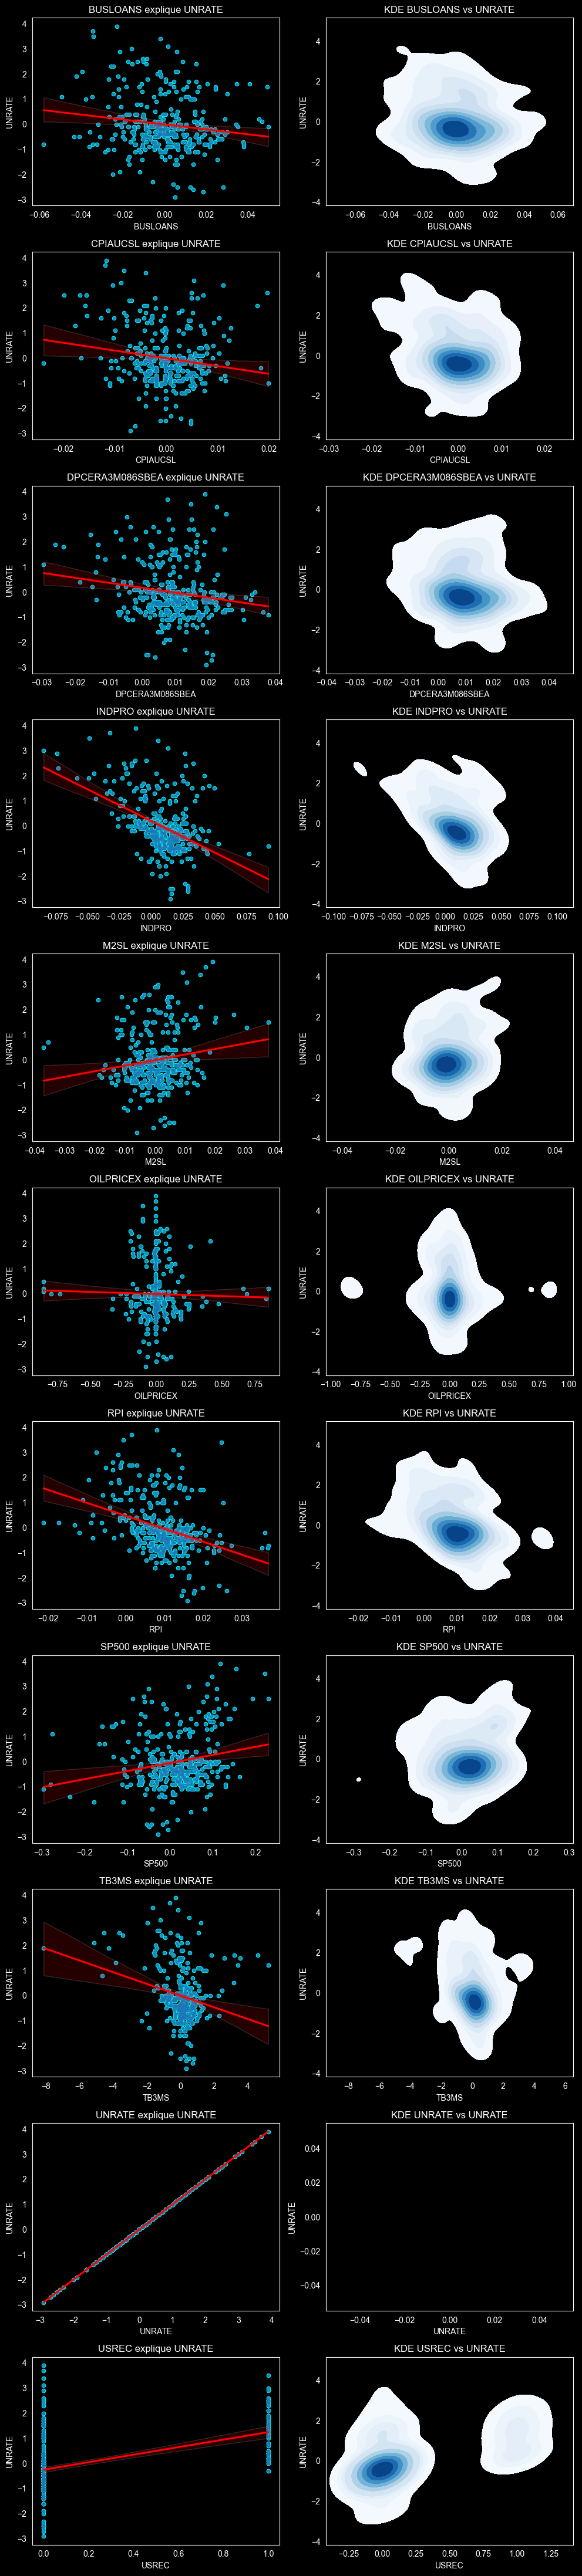

In [73]:
cols = df_train.columns.to_list()

sns.set_style("dark")  # style sombre seaborn

fig, axes = plt.subplots(
    nrows=len(cols), ncols=2,
    figsize=(10, 4*len(cols)),
    facecolor="black"  # fond de la figure en noir
)

for ax_row, col in zip(axes, cols):
    ax_scatter, ax_kde = ax_row

    # Couleur de fond des axes en noir
    ax_scatter.set_facecolor("black")
    ax_kde.set_facecolor("black")

    # === SCATTER + REGRESSION ===
    df_train.plot.scatter(
        x=col, y="UNRATE", ax=ax_scatter, color="cyan"
    )
    sns.regplot(
        data=df_train, x=col, y="UNRATE",
        ax=ax_scatter, scatter_kws={'s':10}, line_kws={"color":"red"}
    )
    ax_scatter.set_title(f"{col} explique UNRATE", color="white")
    ax_scatter.tick_params(colors="white")
    ax_scatter.xaxis.label.set_color("white")
    ax_scatter.yaxis.label.set_color("white")

    # === KDE PLOT ===
    sns.kdeplot(
        data=df_train,
        x=col, y="UNRATE",
        fill=True,
        cmap="Blues",
        ax=ax_kde
    )
    ax_kde.set_title(f"KDE {col} vs UNRATE", color="white")
    ax_kde.tick_params(colors="white")
    ax_kde.xaxis.label.set_color("white")
    ax_kde.yaxis.label.set_color("white")

plt.tight_layout()
plt.show()